# Лабораторная работа. Антоненко Елизавета. ИТМО

# Описание набора данных
В данной работе целью исследования будет набор данных Titanic. Данный набор содержит информацию о различных пассажирах корабля "Титаник", затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д. Мы предлагаем вам натренировать нейронную сеть для бинарной классификации, способную предсказывать вероятность спасения человека на основе его данных.  

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы - отдельный пассажир, вся информация о нем содержится в его строке. В столбце survived находится бинарная метка (0 или 1), означающая, спасся ли человек с корабля (1) или нет (0). Вашей задачей является изучить набор данных, корректно определить решаемую задачу, а затем построить модель, которая будет способна предсказывать вероятность спасения и посчитать F1-метрику на тестовом наборе данных.

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf

In [ ]:
(ds_train_tf, ds_test_tf), ds_info = tfds.load(
    name='titanic',
    split=['train[:90%]', 'train[90%:]'],
    #as_supervised=True,
    with_info=True
)

In [ ]:
len(ds_train_tf)

1178

По умолчанию библиотека загружает данные в формате TensorFlow Dataset. Этот формат позволяет оперировать данными на жестком диске без предварительной загрузки их в память, что позволят обучать модели на данных, превышающих размер оперативной памяти вашего устройства.

Набор данных Titanic является достаточно небольшим набором и мы уверены, что оперативной памяти вашего устройства хватит для хранения его целиком, поэтому это в данный момент не играет решающей роли. Однако, вам будет полезно научиться работать с ним.

Примеры использования и различных функций этого формата данных вы можете найти в документации или Jupyter Notebook'е данного курса, описывающем работу с библиотекой Keras.

Давайте выведем первую строку тренировочного набора данных для ознакомления.

In [ ]:
ds_train = tfds.as_dataframe(ds_train_tf.take(len(ds_train_tf)), ds_info)
ds_test = tfds.as_dataframe(ds_test_tf.take(len(ds_test_tf)), ds_info)
ds_train.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,30.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1,0,0,0,b'233478'
1,37.0,b'Unknown',98,b'Unknown',2,7.9250,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2,0,2,0,b'3101276'
2,28.0,b'9',-1,b'Unknown',2,13.0000,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1,1,0,1,b'230434'
3,18.0,b'Unknown',-1,b'Unknown',2,73.5000,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1,0,0,0,b'S.O.C. 14879'
4,-1.0,b'Unknown',-1,b'Unknown',0,7.8958,b'Unknown',"b'Gheorgheff, Mr. Stanio'",0,2,0,0,0,b'349254'


In [ ]:
ds_train.shape, ds_test.shape

((1178, 14), (131, 14))

# Предобработка данных

In [ ]:
ds_train.nunique()

age            99
boat           28
body          112
cabin         178
embarked        4
fare          271
home.dest     350
name         1176
parch           8
pclass          3
sex             2
sibsp           7
survived        2
ticket        855
dtype: int64

In [ ]:
# Удаляем 'name', потому что в столбце для каждого наблюдения свое уникальное значение, поэтому данный параметр не несет никакой информации.
ds_train = ds_train.drop(['name'], axis=1)
ds_test = ds_test.drop(['name'], axis=1)

### Анализ NULL и UNKNOWN значений

In [ ]:
# True in ds_train.isnull()
ds_train.isnull().iloc[ds_train.shape[1],]
#ds_test.isnull().iloc[ds_test.shape[1],]

age          False
boat         False
body         False
cabin        False
embarked     False
fare         False
home.dest    False
parch        False
pclass       False
sex          False
sibsp        False
survived     False
ticket       False
Name: 13, dtype: bool

**Вывод**: Null-значения отсутствуют.

In [ ]:
ds_train['home.dest'].value_counts()

b'Unknown'                    504
b'New York, NY'                61
b'London'                      14
b'Paris, France'                9
b'Montreal, PQ'                 9
                             ... 
b'London  Vancouver, BC'        1
b'Southsea, Hants'              1
b'Columbus, OH'                 1
b'Cornwall / Houghton, MI'      1
b'?Havana, Cuba'                1
Name: home.dest, Length: 350, dtype: int64

In [ ]:
ds_train['home.dest'] = ds_train['home.dest'].astype('string')
ds_train.loc[(ds_train['home.dest'] == "b'Unknown'"), 'home.dest'] = "b'New York, NY'"

ds_test['home.dest'] = ds_test['home.dest'].astype('string')
ds_test.loc[(ds_test['home.dest'] == "b'Unknown'"), 'home.dest'] = "b'New York, NY'"

In [ ]:
ds_train['boat'].value_counts()

b'Unknown'    736
b'13'          37
b'C'           33
b'15'          31
b'14'          29
b'4'           27
b'10'          27
b'5'           27
b'3'           24
b'11'          23
b'8'           22
b'16'          21
b'7'           21
b'6'           20
b'D'           19
b'9'           19
b'12'          18
b'2'           13
b'A'           10
b'B'            8
b'1'            4
b'5 7'          2
b'13 15'        2
b'C D'          1
b'15 16'        1
b'5 9'          1
b'13 15 B'      1
b'8 10'         1
Name: boat, dtype: int64

In [ ]:
ds_train['cabin'].value_counts()

b'Unknown'        905
b'C23 C25 C27'      6
b'G6'               5
b'D'                4
b'F2'               4
                 ... 
b'E49'              1
b'B30'              1
b'D46'              1
b'C104'             1
b'D43'              1
Name: cabin, Length: 178, dtype: int64

**Вывод**: В столбцах 'boat' и 'cabin' Unknown значения содержатся более чем у половины наблюдений, поэтому можно сделать вывод, что данные параметры не принесут много информации для обучения, а заменить их медианным значением не имеет смысла, но мы рассмотрим 2 датасета. Один с медианными значениями вместо Unknown, другой без данных столбцов.

In [ ]:
ds_train = ds_train.drop(['boat'], axis=1).drop(['cabin'], axis=1)
ds_test = ds_test.drop(['boat'], axis=1).drop(['cabin'], axis=1)
ds_train.shape, ds_test.shape

((1178, 11), (131, 11))

### Приведение к одному типу данных

In [ ]:
ds_train.dtypes

age          float32
body           int32
embarked       int64
fare         float32
home.dest     string
parch          int32
pclass         int64
sex            int64
sibsp          int32
survived       int64
ticket        object
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
ds_train['home.dest'] = labelencoder.fit_transform(ds_train['home.dest'])
ds_train['ticket'] = labelencoder.fit_transform(ds_train['ticket'])

ds_train['age'] = ds_train['age'].astype(int)
ds_train['fare'] = ds_train['fare'].astype(int)
ds_train['body'] = ds_train['body'].astype(int)
ds_train['parch'] = ds_train['parch'].astype(int)
ds_train['sibsp'] = ds_train['sibsp'].astype(int)


ds_test['home.dest'] = labelencoder.fit_transform(ds_test['home.dest'])
ds_test['ticket'] = labelencoder.fit_transform(ds_test['ticket'])

ds_test['age'] = ds_test['age'].astype(int)
ds_test['fare'] = ds_test['fare'].astype(int)
ds_test['body'] = ds_test['body'].astype(int)
ds_test['parch'] = ds_test['parch'].astype(int)
ds_test['sibsp'] = ds_test['sibsp'].astype(int)

In [ ]:
ds_train.dtypes

age          int64
body         int64
embarked     int64
fare         int64
home.dest    int64
parch        int64
pclass       int64
sex          int64
sibsp        int64
survived     int64
ticket       int64
dtype: object

In [ ]:
ds_train.head()

,age,body,embarked,fare,home.dest,parch,pclass,sex,sibsp,survived,ticket
0,30,-1,2,13,271,0,1,0,0,0,141
1,37,98,2,7,266,0,2,0,2,0,307
2,28,-1,2,13,283,0,1,1,0,1,138
3,18,-1,2,73,208,0,1,0,0,0,780
4,-1,-1,0,7,230,0,2,0,0,0,491


### Обработка столбца 'age'

In [ ]:
ds_train['age'].value_counts()

-1     230
 24     44
 30     40
 22     39
 18     37
      ... 
 80      1
 74      1
 66      1
 67      1
 76      1
Name: age, Length: 74, dtype: int64

Значение "-1" у возраста быть не может. Заменим на среднее.


In [ ]:
mean_age = ds_train.loc[(ds_train['age'] > 0), 'age'].mean().astype(int)
ds_train.loc[(ds_train['age'] < 0), 'age'] = mean_age

mean_age_test = ds_test.loc[(ds_test['age'] > 0), 'age'].mean().astype(int)
ds_test.loc[(ds_test['age'] < 0), 'age'] = mean_age_test

### Еще раз посмотрим на переменные в ds_train

In [ ]:
ds_train.describe()

,age,body,embarked,fare,home.dest,parch,pclass,sex,sibsp,survived,ticket
count,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000
mean,30.076401,14.517827,1.491511,33.488115,206.258065,0.379457,1.279287,0.357385,0.498302,0.384550,427.971986
std,13.013917,56.815028,0.820518,52.891501,75.892915,0.842470,0.844350,0.479433,1.046293,0.486695,256.106383
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,-1.000000,1.000000,7.000000,188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,195.250000
50%,30.000000,-1.000000,2.000000,14.000000,230.000000,0.000000,2.000000,0.000000,0.000000,0.000000,427.500000
75%,35.750000,-1.000000,2.000000,31.000000,230.000000,0.000000,2.000000,1.000000,1.000000,1.000000,670.750000
max,80.000000,328.000000,3.000000,512.000000,348.000000,9.000000,2.000000,1.000000,8.000000,1.000000,854.000000


Наши выходные данные - столбец survived. Проверим на взвешенность.

In [ ]:
ds_train['survived'].value_counts()

0    725
1    453
Name: survived, dtype: int64

### Матрица корреляции

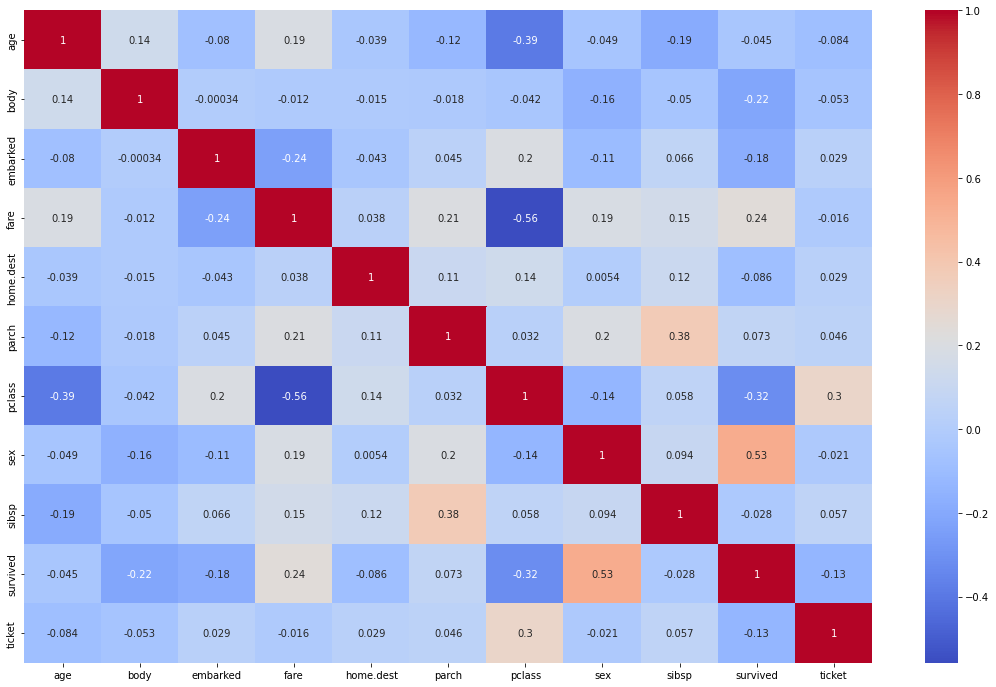

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = ds_train.corr()
plt.figure(figsize=(19, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Вывод**: нет пар с высоким коэффициентом корреляции (>0.7)

# Обучение

### Обучение с параметрами, выбранными вручную

In [ ]:
ds_train.iloc[:, :-1]

,age,body,embarked,fare,home.dest,parch,pclass,sex,sibsp,survived
0,30,-1,2,13,271,0,1,0,0,0
1,37,98,2,7,266,0,2,0,2,0
2,28,-1,2,13,283,0,1,1,0,1
3,18,-1,2,73,208,0,1,0,0,0
4,30,-1,0,7,230,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1173,30,-1,2,7,230,0,2,0,0,0
1174,38,-1,0,71,230,0,0,1,1,1
1175,41,-1,0,15,230,0,1,0,0,0
1176,29,-1,2,9,230,0,2,0,0,1


In [ ]:
X_train = ds_train.drop(['survived'], axis=1).values
y_train = ds_train['survived'].values

X_test = ds_test.drop(['survived'], axis=1).values
y_test = ds_test['survived'].values

X_train.shape, X_test.shape

((1178, 10), (131, 10))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle= True)
X_train.shape, X_valid.shape

((1060, 10), (118, 10))

In [ ]:
# Стандартизуем
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_valid = sc.fit_transform(X_valid)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import activations, layers, optimizers, losses, metrics

In [ ]:
classifier = Sequential()
classifier.add(layers.Dense(16, input_dim = X_train.shape[1], activation = 'relu'))
classifier.add(layers.Dense(8, activation = 'relu'))
classifier.add(layers.Dense(1, activation = 'sigmoid'))
classifier.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 16)                176       
                                                                 
 dense_225 (Dense)           (None, 8)                 136       
                                                                 
 dense_226 (Dense)           (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), shuffle=True)

Epoch 1/50
34/34 [==============================] - 2s 25ms/step - loss: 0.6645 - accuracy: 0.5887 - val_loss: 0.6484 - val_accuracy: 0.6271
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6258 - accuracy: 0.6604 - val_loss: 0.6135 - val_accuracy: 0.6610
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.6000 - accuracy: 0.6792 - val_loss: 0.5855 - val_accuracy: 0.7119
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 0.5789 - accuracy: 0.6991 - val_loss: 0.5607 - val_accuracy: 0.7627
Epoch 5/50
34/34 [==============================] - 0s 9ms/step - loss: 0.5605 - accuracy: 0.7170 - val_loss: 0.5373 - val_accuracy: 0.7966
Epoch 6/50
34/34 [==============================] - 0s 9ms/step - loss: 0.5432 - accuracy: 0.7377 - val_loss: 0.5114 - val_accuracy: 0.8051
Epoch 7/50
34/34 [==============================] - 0s 11ms/step - loss: 0.5246 - accuracy: 0.7604 - val_loss: 0.4862 - val_accuracy: 0.8220
Epoch 8/50
34/34 [

### Подбор гиперпараметров с помощью Optuna

In [ ]:
#!pip install optuna

In [ ]:
import optuna

In [ ]:
def optuna_objective(trial: optuna.trial.Trial):
    model = keras.Sequential(
        [
            layers.Dense(
                units=trial.suggest_int('l1_neurons', 8, 16),
                input_dim=X_train.shape[1],
                activation=trial.suggest_categorical('l1_activation', ['sigmoid', 'relu'])
            ),
            layers.Dense(
                units=trial.suggest_int('l2_neurons', 2, 8),
                activation=trial.suggest_categorical('l2_activation', ['sigmoid', 'relu'])
            ),
            layers.Dense(1, activation = 'sigmoid')
        ]
    )
    
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    
    history = model.fit(X_train, y_train, epochs = 50, verbose = 0, validation_data = (X_valid, y_valid), shuffle=True)
    accuracy = history.history['val_accuracy'][-1]
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2022-11-04 15:07:09,743] A new study created in memory with name: no-name-a9e84559-8423-4034-9c22-1f72985da291


In [ ]:
study.optimize(optuna_objective, n_trials = 20)

[I 2022-11-04 15:07:21,853] Trial 0 finished with value: 0.8305084705352783 and parameters: {'l1_neurons': 16, 'l1_activation': 'sigmoid', 'l2_neurons': 4, 'l2_activation': 'relu'}. Best is trial 0 with value: 0.8305084705352783.
[I 2022-11-04 15:07:32,767] Trial 1 finished with value: 0.8220338821411133 and parameters: {'l1_neurons': 14, 'l1_activation': 'sigmoid', 'l2_neurons': 6, 'l2_activation': 'sigmoid'}. Best is trial 0 with value: 0.8305084705352783.
[I 2022-11-04 15:07:39,369] Trial 2 finished with value: 0.8305084705352783 and parameters: {'l1_neurons': 13, 'l1_activation': 'sigmoid', 'l2_neurons': 5, 'l2_activation': 'relu'}. Best is trial 0 with value: 0.8305084705352783.
[I 2022-11-04 15:07:45,795] Trial 3 finished with value: 0.8220338821411133 and parameters: {'l1_neurons': 14, 'l1_activation': 'sigmoid', 'l2_neurons': 3, 'l2_activation': 'relu'}. Best is trial 0 with value: 0.8305084705352783.
[I 2022-11-04 15:07:56,777] Trial 4 finished with value: 0.8559321761131287 a

In [ ]:
study.best_params

{'l1_neurons': 14,
 'l1_activation': 'relu',
 'l2_neurons': 4,
 'l2_activation': 'sigmoid'}

### Качество модели на тестовом наборе

Нашли лучшие параметры, теперь посмотрим модель и проверим ее на тестовом наборе

In [ ]:
classifier = Sequential()
classifier.add(layers.Dense(14, input_dim = X_train.shape[1], activation = 'relu'))
classifier.add(layers.Dense(4, activation = 'sigmoid'))
classifier.add(layers.Dense(1, activation = 'sigmoid'))

classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), shuffle=True, verbose = 0)

Epoch 1/50
34/34 [==============================] - 1s 8ms/step - loss: 0.6559 - accuracy: 0.6057 - val_loss: 0.6435 - val_accuracy: 0.6102
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6236 - val_loss: 0.6295 - val_accuracy: 0.6186
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6396 - val_loss: 0.6141 - val_accuracy: 0.6441
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6557 - val_loss: 0.5982 - val_accuracy: 0.6695
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6943 - val_loss: 0.5818 - val_accuracy: 0.7203
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.5898 - accuracy: 0.7151 - val_loss: 0.5645 - val_accuracy: 0.7373
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5769 - accuracy: 0.7321 - val_loss: 0.5482 - val_accuracy: 0.7712
Epoch 8/50
34/34 [==

In [ ]:
prediction = classifier.predict(X_test).tolist()
se = pd.Series(prediction)
y_test_pred = se.str.get(0)
[y_test.shape, y_test_pred.shape]

5/5 [==============================] - 0s 3ms/step


[(131,), (131,)]

In [ ]:
def choose_class(y_test_pred):
  for i in range(len(y_test_pred)):
    if y_test_pred[i] >= 0.5:
      y_test_pred[i] = 1
    else:
      y_test_pred[i] = 0
  return y_test_pred

In [ ]:
y_test_pred = choose_class(y_test_pred)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy на тестовой выборке', accuracy_score(y_test, y_test_pred, normalize=True))
print(' ')
print(classification_report(y_test, y_test_pred))

Accuracy на тестовой выборке 0.7938931297709924
 
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        84
           1       0.74      0.66      0.70        47

    accuracy                           0.79       131
   macro avg       0.78      0.76      0.77       131
weighted avg       0.79      0.79      0.79       131



**Вывод**: 0.79 - очень неплохой результат!

### Подбор гиперпараметров "optimizer", "epochs", "batch_size" с помощью GridSearchCV

Возьмем лучшие параметры, посчитанные с помощью optuna

In [ ]:
def build_classifier(optimizer):
  classifier = Sequential()
  classifier.add(Dense(14, input_dim = X_train.shape[1], activation = 'relu'))
  classifier.add(Dense(4, activation = 'sigmoid'))
  classifier.add(Dense(1, activation = 'sigmoid'))
  classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return classifier

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
classifier = KerasClassifier(build_fn = build_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
from sklearn.model_selection import GridSearchCV

In [242]:
param_grid = dict(optimizer = ['adam', 'rmsprop'],
                  epochs=[50, 100, 200],
                  batch_size=[5, 10, 20])
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy')
grid_result = grid.fit(X_train, y_train, validation_data = (X_valid, y_valid), shuffle=True)
best_parameters = grid.best_params_
best_accuracy = grid.best_score_

Выходные данные были обрезаны до нескольких последних строк (5000).
43/43 [==============================] - 0s 7ms/step - loss: 0.5084 - accuracy: 0.8042 - val_loss: 0.4853 - val_accuracy: 0.8390
Epoch 9/100
43/43 [==============================] - 0s 6ms/step - loss: 0.4935 - accuracy: 0.8066 - val_loss: 0.4669 - val_accuracy: 0.8475
Epoch 10/100
43/43 [==============================] - 0s 6ms/step - loss: 0.4814 - accuracy: 0.8066 - val_loss: 0.4523 - val_accuracy: 0.8390
Epoch 11/100
43/43 [==============================] - 0s 6ms/step - loss: 0.4722 - accuracy: 0.8160 - val_loss: 0.4392 - val_accuracy: 0.8390
Epoch 12/100
43/43 [==============================] - 0s 6ms/step - loss: 0.4646 - accuracy: 0.8219 - val_loss: 0.4286 - val_accuracy: 0.8390
Epoch 13/100
43/43 [==============================] - 0s 5ms/step - loss: 0.4583 - accuracy: 0.8219 - val_loss: 0.4197 - val_accuracy: 0.8390
Epoch 14/100
43/43 [==============================] - 0s 5ms/step - loss: 0.4536 - accuracy: 0

In [243]:
classifier = KerasClassifier(build_fn = build_classifier,
                             optimizer=best_parameters['optimizer'],
                             batch_size=best_parameters['batch_size'],
                             epochs=best_parameters['epochs'])

classifier.fit(X_train,y_train)
preds = classifier.predict(X_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


53/53 [==============================] - 1s 4ms/step - loss: 0.6693 - accuracy: 0.6160
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6509 - accuracy: 0.6160
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6160
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6170
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5912 - accuracy: 0.6585
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5693 - accuracy: 0.7292
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5495 - accuracy: 0.7642
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5314 - accuracy: 0.7925
Epoch 9/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5159 - accuracy: 0.7981
Epoch 10/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5028 - accuracy: 0.8028
Epoch 11/100
53/53 [=

In [244]:
prediction = preds.tolist()
se = pd.Series(prediction)
y_test_pred = se.str.get(0)
[y_test.shape, y_test_pred.shape]

[(131,), (131,)]

In [245]:
y_test_pred = choose_class(y_test_pred)

In [246]:
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_test_pred, normalize=True))
print(' ')
print(classification_report(y_test, y_test_pred))

Accuracy на тестовой выборке 0.7938931297709924
 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        84
           1       0.79      0.57      0.67        47

    accuracy                           0.79       131
   macro avg       0.79      0.75      0.76       131
weighted avg       0.79      0.79      0.78       131



**Вывод**: Предсказания на тестовых данных чуть хуже. Но ничего. Живем-живем